# Vijay vs Rajinikanth – Global Box Office Popularity Analysis

This notebook analyzes the worldwide box office performance of Vijay and Rajinikanth over the past two decades.  
We will examine trends in domestic vs international markets, release timing, pre-release engagement metrics, and factors that predict opening weekend success.

**Goal:** Show how entertainment consumption data can inform broader analytics applications in music streaming, retail, and e-commerce.

In [4]:
# Basic data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

# APIs & scraping
import requests
from bs4 import BeautifulSoup

# Date handling
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Data Collection Plan

We will collect the following datasets:
1. **Box Office Data** – Worldwide gross, domestic vs international breakdown (Box Office Mojo, The Numbers, Wikipedia).
2. **Movie Metadata** – Budget, release date, distributor, genre.
3. **Engagement Data** – Google Trends search interest, YouTube trailer views before release.
4. **Release Timing** – Festival vs non-festival, solo vs competing release.

In [16]:
films = {
    "Vijay": {
        "Bigil": "https://en.wikipedia.org/wiki/Bigil",
        "Master": "https://en.wikipedia.org/wiki/Master_(2021_film)",
        "Varisu": "https://en.wikipedia.org/wiki/Varisu",
        "Leo": "https://en.wikipedia.org/wiki/Leo_(2023_Indian_film)",
        "The Greatest of All Time": "https://en.wikipedia.org/wiki/The_Greatest_of_All_Time"
    },
    "Rajinikanth": {
        "Petta": "https://en.wikipedia.org/wiki/Petta_(film)",
        "Darbar": "https://en.wikipedia.org/wiki/Darbar_(film)",
        "Annaatthe": "https://en.wikipedia.org/wiki/Annaatthe",
        "Jailer": "https://en.wikipedia.org/wiki/Jailer_(2023_Tamil_film)",
        "Lal Salaam": "https://en.wikipedia.org/wiki/Lal_Salaam_(2024_film)",
        "Vettaiyan": "https://en.wikipedia.org/wiki/Vettaiyan"
    }
}

def scrape_wiki_box_office_v4(film_title, wiki_url):
    # (Use the function from earlier with budget skipped)
    resp = requests.get(wiki_url)
    soup = BeautifulSoup(resp.text, "html.parser")

    data = {"Title": film_title}

    infobox = soup.find("table", class_="infobox vevent")
    if infobox:
        rows = infobox.find_all("tr")
        for row in rows:
            header = row.find("th")
            value = row.find("td")
            if header and value:
                key = header.get_text(strip=True)
                val_text = value.get_text(separator=" ", strip=True)
                if key.lower() == "budget":
                    continue
                if ("gross" in key.lower()) or ("box office" in key.lower()):
                    cleaned = clean_wiki_value(val_text)
                    data[key] = cleaned

    data["Actor"] = None  # to add actor info
    return pd.DataFrame([data])

def clean_wiki_value(text):
    import re
    text = re.sub(r"\[\s*[a-z0-9]+\s*\]", "", text)
    text = text.replace("₹", "").replace("est.", "").strip()
    return text

dfs = []

for actor, movies in films.items():
    for title, url in movies.items():
        df = scrape_wiki_box_office_v4(title, url)
        df["Actor"] = actor
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(df_all)

                       Title     Box office        Actor
0                      Bigil  285–300 crore        Vijay
1                     Master  220–300 crore        Vijay
2                     Varisu  290–293 crore        Vijay
3                        Leo      595 crore        Vijay
4   The Greatest of All Time  440−456 crore        Vijay
5                      Petta  219–250 crore  Rajinikanth
6                     Darbar  202—250 crore  Rajinikanth
7                  Annaatthe  140–240 crore  Rajinikanth
8                     Jailer  605–650 crore  Rajinikanth
9                 Lal Salaam   19.76 crores  Rajinikanth
10                 Vettaiyan  240−250 crore  Rajinikanth


In [17]:
import numpy as np
import re

def parse_box_office_range(value_str):
    # Normalize dashes (hyphen, ndash, mdash)
    value_str = value_str.replace("−", "-").replace("—", "-").replace("–", "-").lower()
    # Remove 'crore(s)' and extra spaces
    value_str = re.sub(r"crores?", "", value_str).strip()
    
    # If it’s a range like "285-300"
    if "-" in value_str:
        parts = value_str.split("-")
        try:
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            return low, high
        except:
            return np.nan, np.nan
    else:
        # Single value
        try:
            val = float(value_str)
            return val, val
        except:
            return np.nan, np.nan

# Apply this parsing to your df_all
df_all["BoxOffice_Min"], df_all["BoxOffice_Max"] = zip(*df_all["Box office"].map(parse_box_office_range))

df_all_clean = df_all.drop(columns=["Box office"])
print(df_all_clean)

                       Title        Actor  BoxOffice_Min  BoxOffice_Max
0                      Bigil        Vijay         285.00         300.00
1                     Master        Vijay         220.00         300.00
2                     Varisu        Vijay         290.00         293.00
3                        Leo        Vijay         595.00         595.00
4   The Greatest of All Time        Vijay         440.00         456.00
5                      Petta  Rajinikanth         219.00         250.00
6                     Darbar  Rajinikanth         202.00         250.00
7                  Annaatthe  Rajinikanth         140.00         240.00
8                     Jailer  Rajinikanth         605.00         650.00
9                 Lal Salaam  Rajinikanth          19.76          19.76
10                 Vettaiyan  Rajinikanth         240.00         250.00


In [57]:
import pandas as pd

# Your existing df_all (just a sample schema here, replace with your real df_all)
data = {
    "Title": ["Bigil", "Master", "Varisu", "Leo", "The Greatest of All Time", "Petta", "Darbar", "Annaatthe", "Jailer", "Lal Salaam", "Vettaiyan"],
    "Actor": ["Vijay", "Vijay", "Vijay", "Vijay", "Vijay", "Rajinikanth", "Rajinikanth", "Rajinikanth", "Rajinikanth", "Rajinikanth", "Rajinikanth"],
    # This column you had before in USD million, we will replace with INR crores here to keep consistent with hardcoding
    "BoxOffice_Min": [285, 220, 290, 603, 440, 219, 202, 140, 605, 19.76, 240],
    "BoxOffice_Max": [300, 300, 293, 623, 456, 250, 250, 240, 605, 19.76, 250]
}

df_all = pd.DataFrame(data)
df_all

,Title,Actor,BoxOffice_Min,BoxOffice_Max
0,Bigil,Vijay,285.00,300.00
1,Master,Vijay,220.00,300.00
2,Varisu,Vijay,290.00,293.00
3,Leo,Vijay,603.00,623.00
4,The Greatest of All Time,Vijay,440.00,456.00
5,Petta,Rajinikanth,219.00,250.00
6,Darbar,Rajinikanth,202.00,250.00
7,Annaatthe,Rajinikanth,140.00,240.00
8,Jailer,Rajinikanth,605.00,605.00
9,Lal Salaam,Rajinikanth,19.76,19.76


In [58]:
# Constants
INR_TO_USD_RATE = 87.58

# Convert crores to INR millions (1 crore = 10 million)
df_all["BoxOffice_Min_INR_million"] = df_all["BoxOffice_Min"] * 10
df_all["BoxOffice_Max_INR_million"] = df_all["BoxOffice_Max"] * 10

# Convert INR millions to USD millions
df_all["BoxOffice_Min_USD_million"] = df_all["BoxOffice_Min_INR_million"] / INR_TO_USD_RATE
df_all["BoxOffice_Max_USD_million"] = df_all["BoxOffice_Max_INR_million"] / INR_TO_USD_RATE

# Optional: rounded USD columns for cleaner display
df_all["BoxOffice_Min_USD_million"] = df_all["BoxOffice_Min_USD_million"].round(2)
df_all["BoxOffice_Max_USD_million"] = df_all["BoxOffice_Max_USD_million"].round(2)

df_all[[
    "Title", "Actor", 
    "BoxOffice_Min_USD_million", "BoxOffice_Max_USD_million"
]]

,Title,Actor,BoxOffice_Min_USD_million,BoxOffice_Max_USD_million
0,Bigil,Vijay,32.54,34.25
1,Master,Vijay,25.12,34.25
2,Varisu,Vijay,33.11,33.46
3,Leo,Vijay,68.85,71.13
4,The Greatest of All Time,Vijay,50.24,52.07
5,Petta,Rajinikanth,25.01,28.55
6,Darbar,Rajinikanth,23.06,28.55
7,Annaatthe,Rajinikanth,15.99,27.40
8,Jailer,Rajinikanth,69.08,69.08
9,Lal Salaam,Rajinikanth,2.26,2.26


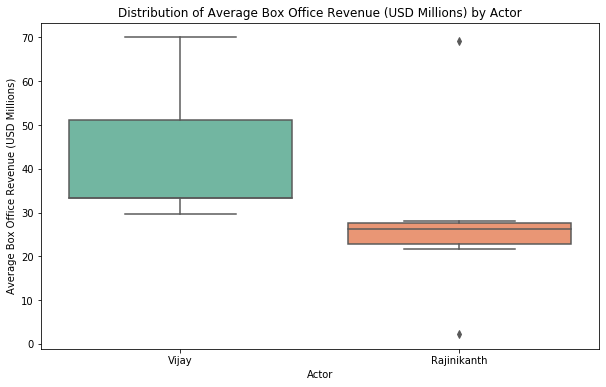

In [59]:
df_all["BoxOffice_Mean_USD_million"] = (df_all["BoxOffice_Min_USD_million"] + df_all["BoxOffice_Max_USD_million"]) / 2

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x="Actor", y="BoxOffice_Mean_USD_million", palette="Set2")
plt.title("Distribution of Average Box Office Revenue (USD Millions) by Actor")
plt.ylabel("Average Box Office Revenue (USD Millions)")
plt.xlabel("Actor")
plt.show()

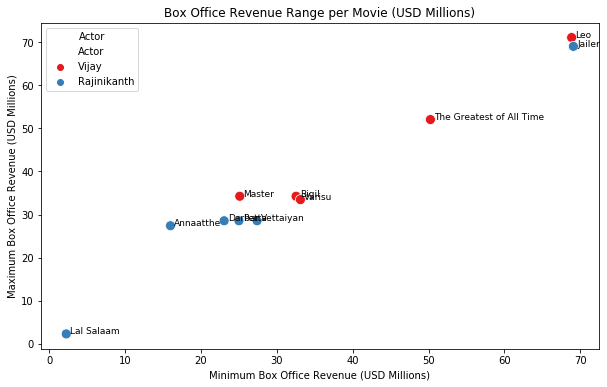

In [60]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_all, x="BoxOffice_Min_USD_million", y="BoxOffice_Max_USD_million", hue="Actor", s=100, palette="Set1")

for i, row in df_all.iterrows():
    plt.text(row["BoxOffice_Min_USD_million"] + 0.5, row["BoxOffice_Max_USD_million"], row["Title"], fontsize=9)

plt.title("Box Office Revenue Range per Movie (USD Millions)")
plt.xlabel("Minimum Box Office Revenue (USD Millions)")
plt.ylabel("Maximum Box Office Revenue (USD Millions)")
plt.legend(title="Actor")
plt.show()

In [61]:
release_years = {
    "Bigil": 2019,
    "Master": 2021,
    "Varisu": 2023,
    "Leo": 2023,
    "The Greatest of All Time": 2024,
    "Petta": 2019,
    "Darbar": 2020,
    "Annaatthe": 2021,
    "Jailer": 2023,
    "Lal Salaam": 2024,
    "Vettaiyan": 2024
}

df_all["Release_Year"] = df_all["Title"].map(release_years)

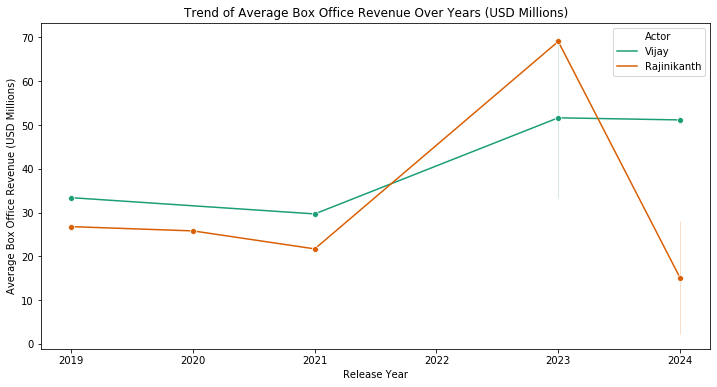

In [62]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_all, x="Release_Year", y="BoxOffice_Mean_USD_million", hue="Actor", marker="o", palette="Dark2")
plt.title("Trend of Average Box Office Revenue Over Years (USD Millions)")
plt.xlabel("Release Year")
plt.ylabel("Average Box Office Revenue (USD Millions)")
plt.show()

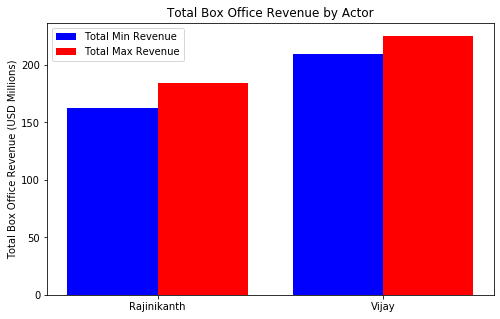

In [63]:
agg_df = df_all.groupby("Actor")[["BoxOffice_Min_USD_million", "BoxOffice_Max_USD_million"]].sum().reset_index()

plt.figure(figsize=(8,5))
bar_width = 0.4
x = range(len(agg_df))

plt.bar(x, agg_df["BoxOffice_Min_USD_million"], width=bar_width, label="Total Min Revenue", color="blue")
plt.bar([i + bar_width for i in x], agg_df["BoxOffice_Max_USD_million"], width=bar_width, label="Total Max Revenue", color="red")

plt.xticks([i + bar_width / 2 for i in x], agg_df["Actor"])
plt.ylabel("Total Box Office Revenue (USD Millions)")
plt.title("Total Box Office Revenue by Actor")
plt.legend()
plt.show()

In [5]:
from pytrends.request import TrendReq

# Connect to Google
pytrends = TrendReq(hl='en-US', tz=330)  # India timezone UTC+5:30

# Choose keywords (search terms)
kw_list = ["Thalapathy Vijay", "Superstar Rajinikanth"]

# Build payload for interest over time from 2018 to now
pytrends.build_payload(kw_list, cat=0, timeframe='2019-01-01 2025-08-10', geo='IN', gprop='')

# Fetch interest over time
interest_over_time_df = pytrends.interest_over_time()

print(interest_over_time_df.head())

interest_over_time_df.to_csv("google_trends.csv", index=True)

            Thalapathy Vijay  Superstar Rajinikanth  isPartial
date                                                          
2019-01-01                 7                      7      False
2019-02-01                 6                      5      False
2019-03-01                 6                      4      False
2019-04-01                 5                      4      False
2019-05-01                 6                      3      False


C:\Users\Gautham Raj\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Gautham Raj\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Gautham Raj\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


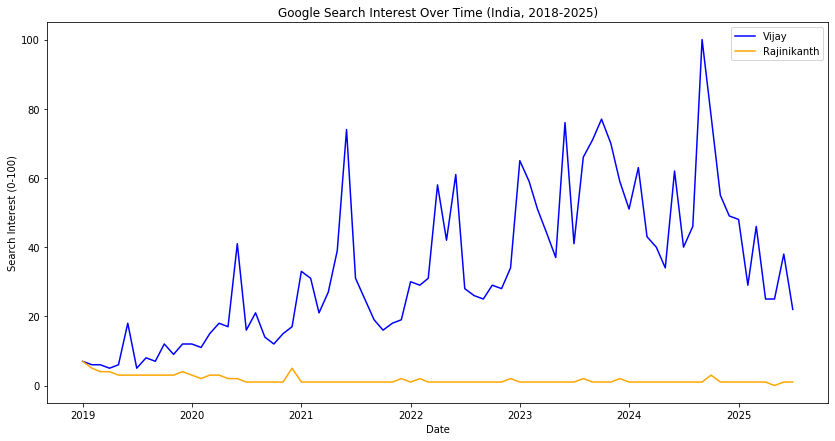

In [3]:
import matplotlib.pyplot as plt

# Drop partial last row if exists
if 'isPartial' in interest_over_time_df.columns:
    interest_over_time_df = interest_over_time_df[~interest_over_time_df['isPartial']]

plt.figure(figsize=(14,7))
plt.plot(interest_over_time_df.index, interest_over_time_df["Thalapathy Vijay"], label="Vijay", color="blue")
plt.plot(interest_over_time_df.index, interest_over_time_df["Superstar Rajinikanth"], label="Rajinikanth", color="orange")
plt.title("Google Search Interest Over Time (India, 2018-2025)")
plt.xlabel("Date")
plt.ylabel("Search Interest (0-100)")
plt.legend()
plt.show()

In [42]:
from googleapiclient.discovery import build
import pandas as pd

API_KEY = #API KEY
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_video_stats(search_query, max_results=10):
    # Search for videos
    search_response = youtube.search().list(
        q=search_query,
        type='video',
        part='id,snippet',
        maxResults=max_results,
        order='relevance',
        publishedAfter='2018-01-01T00:00:00Z'
    ).execute()

    video_ids = [item['id']['videoId'] for item in search_response['items']]

    # Get video details
    stats_response = youtube.videos().list(
        part='statistics,snippet',
        id=','.join(video_ids)
    ).execute()

    records = []
    for item in stats_response['items']:
        snippet = item['snippet']
        stats = item['statistics']
        records.append({
            'videoId': item['id'],
            'title': snippet['title'],
            'publishedAt': snippet['publishedAt'],
            'viewCount': int(stats.get('viewCount', 0)),
            'likeCount': int(stats.get('likeCount', 0)) if 'likeCount' in stats else None,
            'commentCount': int(stats.get('commentCount', 0)) if 'commentCount' in stats else None,
            'search_query': search_query
        })

    return pd.DataFrame(records)

search_terms = [
    "Thalapathy Vijay teaser",
    "Thalapathy Vijay trailer",
    "Rajinikanth teaser",
    "Rajinikanth trailer"
]

def get_stats_multiple_queries(queries, max_results=10):
    all_dfs = []
    for query in queries:
        print(f"Fetching data for: {query}")
        df = get_video_stats(query, max_results=max_results)
        all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)

# Run and get combined data
df_trailers = get_stats_multiple_queries(search_terms, max_results=20)
print(df_trailers.head())

Fetching data for: Thalapathy Vijay teaser
Fetching data for: Thalapathy Vijay trailer
Fetching data for: Rajinikanth teaser
Fetching data for: Rajinikanth trailer
       videoId                                              title  \
0  MKUDHKf_pkg  The First Roar - Jana Nayagan | Thalapathy Vij...   
1  UTiXQcrLlv4  Master - Official Teaser | Thalapathy Vijay | ...   
2  Po3jStA673E  LEO - Official Trailer | Thalapathy Vijay | Lo...   
3  C4oy7FjlpDc  Jana Nayagan - Notion Trailer | Thalapathy Vij...   
4  UT0HyhjyYpg  Jana Nayagan - Official Trailer | Thalapathy V...   

            publishedAt  viewCount  likeCount  commentCount  \
0  2025-06-21T18:29:57Z   33723994     943066         34042   
1  2020-11-14T12:28:14Z   79703844    2887017       1166393   
2  2023-10-05T13:00:12Z   70295112    3123060        167248   
3  2024-10-05T12:30:08Z    1094524      13985           140   
4  2025-02-20T10:30:40Z     714546      11675           305   

              search_query  
0  Thalapathy

In [67]:
# Extract actor and type from search_query
df_trailers['Actor'] = df_trailers['search_query'].apply(lambda x: "Vijay" if "Vijay" in x else "Rajinikanth")
df_trailers['Type'] = df_trailers['search_query'].apply(lambda x: "Teaser" if "teaser" in x.lower() else "Trailer")

# Aggregate sum of views, likes, comments by Actor and Type
agg_stats = df_trailers.groupby(['Actor', 'Type'])[['viewCount', 'likeCount', 'commentCount']].sum().reset_index()

print(agg_stats)

         Actor     Type  viewCount  likeCount  commentCount
0  Rajinikanth   Teaser  281123429    6494524        192442
1  Rajinikanth  Trailer  443509604    7755838        229624
2        Vijay   Teaser  411532368   14825100       1801445
3        Vijay  Trailer  503192919   18104227       1986187


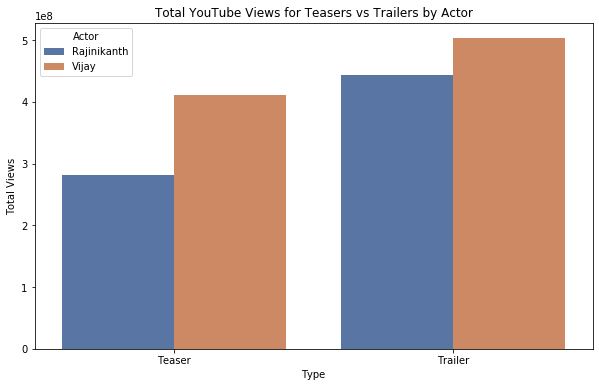

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=agg_stats, x='Type', y='viewCount', hue='Actor', palette='deep')
plt.title('Total YouTube Views for Teasers vs Trailers by Actor')
plt.ylabel('Total Views')
plt.show()

In [69]:
# Manually add India and Overseas gross in INR crores
india_gross = {
    "Bigil": 120, "Master": 175, "Varisu": 140, "Leo": 595, "The Greatest of All Time": 298,
    "Petta": 150, "Darbar": 120, "Annaatthe": 110, "Jailer": 408.5, "Lal Salaam": 15, "Vettaiyan": 223
}

overseas_gross = {
    "Bigil": 75, "Master": 90, "Varisu": 70, "Leo": 28, "The Greatest of All Time": 152,
    "Petta": 80, "Darbar": 70, "Annaatthe": 50, "Jailer": 196, "Lal Salaam": 5, "Vettaiyan": 17
}

df_all['India_Gross_INR_crore'] = df_all['Title'].map(india_gross)
df_all['Overseas_Gross_INR_crore'] = df_all['Title'].map(overseas_gross)

df_all

,Title,Actor,BoxOffice_Min,BoxOffice_Max,BoxOffice_Min_INR_million,BoxOffice_Max_INR_million,BoxOffice_Min_USD_million,BoxOffice_Max_USD_million,BoxOffice_Mean_USD_million,Release_Year,India_Gross_INR_crore,Overseas_Gross_INR_crore
0,Bigil,Vijay,285.00,300.00,2850.0,3000.0,32.54,34.25,33.395,2019,120.0,75
1,Master,Vijay,220.00,300.00,2200.0,3000.0,25.12,34.25,29.685,2021,175.0,90
2,Varisu,Vijay,290.00,293.00,2900.0,2930.0,33.11,33.46,33.285,2023,140.0,70
3,Leo,Vijay,603.00,623.00,6030.0,6230.0,68.85,71.13,69.990,2023,595.0,28
4,The Greatest of All Time,Vijay,440.00,456.00,4400.0,4560.0,50.24,52.07,51.155,2024,298.0,152
5,Petta,Rajinikanth,219.00,250.00,2190.0,2500.0,25.01,28.55,26.780,2019,150.0,80
6,Darbar,Rajinikanth,202.00,250.00,2020.0,2500.0,23.06,28.55,25.805,2020,120.0,70
7,Annaatthe,Rajinikanth,140.00,240.00,1400.0,2400.0,15.99,27.40,21.695,2021,110.0,50
8,Jailer,Rajinikanth,605.00,605.00,6050.0,6050.0,69.08,69.08,69.080,2023,408.5,196
9,Lal Salaam,Rajinikanth,19.76,19.76,197.6,197.6,2.26,2.26,2.260,2024,15.0,5


In [72]:
# Exchange rate (as of now, adjust if needed)
inr_to_usd = 87.58

df_all['India_Gross_USD_million'] = (df_all['India_Gross_INR_crore'] * 1e7) / inr_to_usd / 1e6  # crore to million INR, then to USD
df_all['Overseas_Gross_USD_million'] = (df_all['Overseas_Gross_INR_crore'] * 1e7) / inr_to_usd / 1e6

# Also convert box office min and max (total)
df_all['BoxOffice_Min_USD_million'] = (df_all['BoxOffice_Min_INR_million'] * 1e7) / inr_to_usd / 1e6
df_all['BoxOffice_Max_USD_million'] = (df_all['BoxOffice_Max_INR_million'] * 1e7) / inr_to_usd / 1e6

df_all

,Title,Actor,BoxOffice_Min,BoxOffice_Max,BoxOffice_Min_INR_million,BoxOffice_Max_INR_million,BoxOffice_Min_USD_million,BoxOffice_Max_USD_million,BoxOffice_Mean_USD_million,Release_Year,India_Gross_INR_crore,Overseas_Gross_INR_crore,India_Gross_USD_million,Overseas_Gross_USD_million
0,Bigil,Vijay,285.00,300.00,2850.0,3000.0,325.416762,342.543960,33.395,2019,120.0,75,13.701758,8.563599
1,Master,Vijay,220.00,300.00,2200.0,3000.0,251.198904,342.543960,29.685,2021,175.0,90,19.981731,10.276319
2,Varisu,Vijay,290.00,293.00,2900.0,2930.0,331.125828,334.551267,33.285,2023,140.0,70,15.985385,7.992692
3,Leo,Vijay,603.00,623.00,6030.0,6230.0,688.513359,711.349623,69.990,2023,595.0,28,67.937885,3.197077
4,The Greatest of All Time,Vijay,440.00,456.00,4400.0,4560.0,502.397808,520.666819,51.155,2024,298.0,152,34.026033,17.355561
5,Petta,Rajinikanth,219.00,250.00,2190.0,2500.0,250.057091,285.453300,26.780,2019,150.0,80,17.127198,9.134506
6,Darbar,Rajinikanth,202.00,250.00,2020.0,2500.0,230.646266,285.453300,25.805,2020,120.0,70,13.701758,7.992692
7,Annaatthe,Rajinikanth,140.00,240.00,1400.0,2400.0,159.853848,274.035168,21.695,2021,110.0,50,12.559945,5.709066
8,Jailer,Rajinikanth,605.00,605.00,6050.0,6050.0,690.796986,690.796986,69.080,2023,408.5,196,46.643069,22.379539
9,Lal Salaam,Rajinikanth,19.76,19.76,197.6,197.6,22.562229,22.562229,2.260,2024,15.0,5,1.712720,0.570907


In [74]:
# Mean total box office INR crore for splits
df_all['BoxOffice_Mean_INR_million'] = (df_all['BoxOffice_Min_INR_million'] + df_all['BoxOffice_Max_INR_million']) / 2

df_all['India_Percent'] = df_all['India_Gross_INR_crore'] / df_all['BoxOffice_Mean_INR_million'] * 100
df_all['Overseas_Percent'] = df_all['Overseas_Gross_INR_crore'] / df_all['BoxOffice_Mean_INR_million'] * 100

df_all

,Title,Actor,BoxOffice_Min,BoxOffice_Max,BoxOffice_Min_INR_million,BoxOffice_Max_INR_million,BoxOffice_Min_USD_million,BoxOffice_Max_USD_million,BoxOffice_Mean_USD_million,Release_Year,India_Gross_INR_crore,Overseas_Gross_INR_crore,India_Gross_USD_million,Overseas_Gross_USD_million,BoxOffice_Mean_INR_million,India_Percent,Overseas_Percent
0,Bigil,Vijay,285.00,300.00,2850.0,3000.0,325.416762,342.543960,33.395,2019,120.0,75,13.701758,8.563599,2925.0,4.102564,2.564103
1,Master,Vijay,220.00,300.00,2200.0,3000.0,251.198904,342.543960,29.685,2021,175.0,90,19.981731,10.276319,2600.0,6.730769,3.461538
2,Varisu,Vijay,290.00,293.00,2900.0,2930.0,331.125828,334.551267,33.285,2023,140.0,70,15.985385,7.992692,2915.0,4.802744,2.401372
3,Leo,Vijay,603.00,623.00,6030.0,6230.0,688.513359,711.349623,69.990,2023,595.0,28,67.937885,3.197077,6130.0,9.706362,0.456770
4,The Greatest of All Time,Vijay,440.00,456.00,4400.0,4560.0,502.397808,520.666819,51.155,2024,298.0,152,34.026033,17.355561,4480.0,6.651786,3.392857
5,Petta,Rajinikanth,219.00,250.00,2190.0,2500.0,250.057091,285.453300,26.780,2019,150.0,80,17.127198,9.134506,2345.0,6.396588,3.411514
6,Darbar,Rajinikanth,202.00,250.00,2020.0,2500.0,230.646266,285.453300,25.805,2020,120.0,70,13.701758,7.992692,2260.0,5.309735,3.097345
7,Annaatthe,Rajinikanth,140.00,240.00,1400.0,2400.0,159.853848,274.035168,21.695,2021,110.0,50,12.559945,5.709066,1900.0,5.789474,2.631579
8,Jailer,Rajinikanth,605.00,605.00,6050.0,6050.0,690.796986,690.796986,69.080,2023,408.5,196,46.643069,22.379539,6050.0,6.752066,3.239669
9,Lal Salaam,Rajinikanth,19.76,19.76,197.6,197.6,22.562229,22.562229,2.260,2024,15.0,5,1.712720,0.570907,197.6,7.591093,2.530364


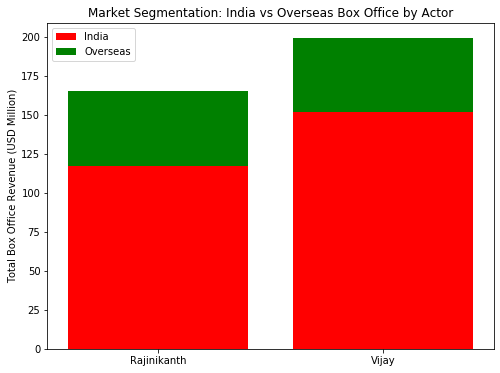

In [76]:
import matplotlib.pyplot as plt

agg_market = df_all.groupby('Actor')[['India_Gross_USD_million', 'Overseas_Gross_USD_million']].sum().reset_index()

plt.figure(figsize=(8,6))
plt.bar(agg_market['Actor'], agg_market['India_Gross_USD_million'], label='India', color='red')
plt.bar(agg_market['Actor'], agg_market['Overseas_Gross_USD_million'], bottom=agg_market['India_Gross_USD_million'], label='Overseas', color='green')

plt.ylabel('Total Box Office Revenue (USD Million)')
plt.title('Market Segmentation: India vs Overseas Box Office by Actor')
plt.legend()
plt.show()

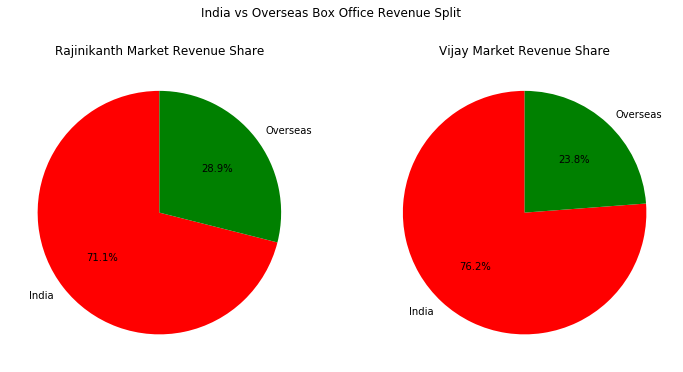

In [79]:
import matplotlib.pyplot as plt

# Aggregate India and Overseas gross by Actor
agg_market = df_all.groupby('Actor')[['India_Gross_USD_million', 'Overseas_Gross_USD_million']].sum()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

colors = ['red', 'green']
labels = ['India', 'Overseas']

for i, actor in enumerate(agg_market.index):
    sizes = agg_market.loc[actor, ['India_Gross_USD_million', 'Overseas_Gross_USD_million']]
    axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    axs[i].set_title(f'{actor} Market Revenue Share')

plt.suptitle('India vs Overseas Box Office Revenue Split')
plt.show()